In [2]:
!pip install open_clip_torch



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x8

In [3]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 3.2 MB/s eta 0:00:00


# Installs

In [4]:
import pandas as pd
import numpy as np
import requests
import os
import torch

import torchvision.transforms.v2 as transforms
import torch.nn as nn

import open_clip
import cv2
from sentence_transformers import util
from PIL import Image


# Mounting

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Reading and Preprocessing the Data

In [17]:

images_ai_1k_df = pd.read_csv("/content/drive/MyDrive/Data Ethics Final Project Drive/1k-ai-images.csv")
images_ai_1k_df

age_description                 jaw_description  \
0               40s                         Rounded   
1           mid 30s                   pointed, soft   
2              90's                     a round jaw   
3                42                        Roundish   
4                37                            Wide   
..              ...                             ...   
995         mid-30s                          Narrow   
996       around 40                           Round   
997         mid-50s                           Round   
998        late 60s       small jawline, loose skin   
999         mid 40s  No beard or facial hair noted    

                                      eyes_description  \
0                                                Hazel   
1                               small, brown, friendly   
2                                      light blue eyes   
3                                                Hazel   
4                                                Brown   
..                                                 ...   
995                                         Dark brown   
996     Could not tell what color but they looked dark   
997                                       Medium brown   
998                         piercing large blue eyes     
999  Large nose in comparison to rest of the facial...   

                                      hair_description  \
0                                          Brown short   
1                               short, brown, straight   
2                                   short cropped hair   
3                                                 Gray   
4                                                Brown   
..                                                 ...   
995                                   Short dark brown   
996                                           Brunette   
997                                        Short black   
998               recieding hair line, short gray hair   
999  Gray hair around the sides with intermixed and...   

                      nose_description race_description  \
0                        Smaller sharp            white   
1                 wide, small nostrils            white   
2                            wide nose            black   
3                              Average            white   
4                               Narrow            white   
..                                 ...              ...   
995                   Long medium size            white   
996                      Somewhat wide         hispanic   
997                        Large stout            black   
998  bulbous snout, wide nose bridge              white   
999               Square-appearing jaw            white   

                                     beard_description gender_description  \
0                                                  NaN             female   
1                              brown, scruffy, mustash               male   
2                                             no beard             female   
3                                          Slight gray               male   
4                                               Shaved               male   
..                                                 ...                ...   
995                                                NaN               male   
996                                                NaN             female   
997                                                NaN               male   
998                            No description provided               male   
999  Smiling expression with wrinkles around the si...               male   

                                  eyebrows_description expression_description  \
0                                                Brown                smiling   
1                                        brown, whispy                smiling   
2                                 thinning light brows                sm

In [18]:
#Importing csv with original filename information
images_1k_df = pd.read_csv("/content/drive/MyDrive/Data Ethics Final Project Drive/1k-images.csv")

#importing csv with AI filename information
images_ai_1k_df = pd.read_csv("/content/drive/MyDrive/Data Ethics Final Project Drive/1k-ai-images.csv")

#Cleaning AI filename information df
images_ai_1k_df['filename'] = images_ai_1k_df['DALLE_images_transformed'].apply(lambda x: x.split('/')[-1])
images_ai_1k_df["filepath_og"] = images_ai_1k_df["Filepath_og_img"].apply(lambda x: x.split('/')[-1])

images_ai_1k_df = images_ai_1k_df[images_ai_1k_df["filename"] != "Google_1_Virginia Hurtado_10_oval.jpg"]

#Dropping erroneous rows from both dataframes
error_df = images_ai_1k_df[images_ai_1k_df["filename"] == "error"]
error_df_lis = list(error_df["filepath_og"])
error_df_lis.append("Google_1_Virginia Hurtado_10_oval.jpg")

images_1k_df_dropped = images_1k_df.loc[~images_1k_df["Filename"].isin(error_df_lis)]
images_ai_1k_df_dropped = images_ai_1k_df[images_ai_1k_df["filename"] != "error"]



In [19]:
#Sorted filename by alphabetical order
images_1k_df_dropped_sorted = images_1k_df_dropped.sort_values(by = "Filename")
images_ai_1k_df_dropped_sorted = images_ai_1k_df_dropped.sort_values(by = "filename")



# CLIP Model Procedure

## Defining the CLIP Model with parameters

In [ ]:
# Creating CLIP model

device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16-plus-240', pretrained="laion400m_e32")
model.to(device)


100%|███████████████████████████████████████| 834M/834M [00:12<00:00, 66.4MiB/s]


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 896, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=896, out_features=896, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=896, out_features=3584, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3584, out_features=896, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((896,), eps=1e-05, elementwise_affine

## Image Vectorization with PyTorch

In [ ]:
#Create class to transform image and extract image features

class ImageTransform():
  def __init__(self, folder_path):
    self.folder_path = folder_path #Grab image directory

  #Function takes in cv2-formatted image and returns the image features encoded by the vision portion of the CLIP model.
  def preprocess_encode_image(self, img):
    img1 = Image.fromarray(img).convert('RGB') #Converts NumPy Array of Image Features into a standardized Image object
    img1 = preprocess(img1).unsqueeze(0).to(device) #preprocess image feature array for use in CLIP model
    img1 = model.encode_image(img1) #Extract image features after encoding with CLIP model
    return img1

  #Function takes in image name and returns an Image
  def img_vectorize(self, image_name):
    test_img = cv2.imread(self.folder_path + image_name, cv2.IMREAD_UNCHANGED) #converts image into numpy array of its features
    return test_img

## Process for Calculating Cosine Similarity Between Two Tensor Objects

In [10]:
#Function takes into two dataframes containing image features and returns a list of similarities,
#where each element is the cosine similarity between a real-image and AI-image pair

def compute_cosine_similarity(image_features_df_1, image_features_df_2):
    similarities = []

    for (index1, row1), (index2, row2) in zip(image_features_df_1.iterrows(), image_features_df_2.iterrows()):

      cos_scores = util.pytorch_cos_sim(torch.tensor(row1, dtype=torch.float32),  torch.tensor(row2, dtype=torch.float32))
      score = round(float(cos_scores[0][0])*100, 2)

      similarities.append(score)

    return similarities

## Fitting CLIP to Our Image Datasets

In [20]:
#Define directory to our image data on google drive
img_directory = '/content/drive/MyDrive/Data Ethics Final Project Drive/1k-MTurk-Images-Experiment/'
ai_img_directory = '/content/drive/MyDrive/Data Ethics Final Project Drive/TRANSFORMED_DALLE_images/'


### Fitting CLIP to Original Image Set

In [ ]:
#Create empty dataframe to add image features by row
img_df_1000_features = pd.DataFrame(columns = list(range(len(images_1k_df_dropped_sorted))))

for image_name in images_1k_df_dropped_sorted["Filename"]: #Iterate through each image filename in the sorted original 1k dataset
  image_instance = ImageTransform(img_directory) #create a ImageTransform object based on the defined directory
  img_vector = image_instance.img_vectorize(image_name) #Call the img_vectorize method from the ImageTranform class to vectorize the image
  image_features = image_instance.preprocess_encode_image(img_vector).flatten().tolist() #encode and reformat image features
  new_row = pd.DataFrame([{idx + 1: x for idx, x in enumerate(image_features)}]) #define new row in dataframe with our image features
  img_df_1000_features = pd.concat([img_df_1000_features, new_row]) #add row to original dataframe

#Save dataframe as csv
img_df_1000_features.to_csv('/content/drive/MyDrive/Data Ethics Final Project Drive/image_feature_df/img_df_1000.csv', index = False)



### Fitting CLIP to AI Image Set

In [ ]:
#Create empty dataframe to add image features by row
ai_img_df_1000_features = pd.DataFrame(columns = list(range(len(images_ai_1k_df_dropped_sorted))))

for image_name in images_ai_1k_df_dropped_sorted["filename"]:#Iterate through each image filename in the sorted AI 1k dataset
  if image_name.endswith('.jpg'): #Check if image name is valid image file
    image_instance = ImageTransform(ai_img_directory) #create a ImageTransform object based on the defined directory
    img_vector = image_instance.img_vectorize(image_name) #Call the img_vectorize method from the ImageTranform class to vectorize the image
    image_features = image_instance.preprocess_encode_image(img_vector).flatten().tolist() #encode and reformat image features
    new_row = pd.DataFrame([{idx + 1: x for idx, x in enumerate(image_features)}]) #define new row in dataframe with our image features
    ai_img_df_1000_features = pd.concat([ai_img_df_1000_features, new_row]) #add row to original dataframe
  else:
    ai_img_df_1000_features = pd.concat([ai_img_df_1000_features, pd.DataFrame([{idx + 1: x for idx, x in enumerate(np.zeros(64))}])], axis = 0)


#Save dataframe as csv
ai_img_df_1000_features.to_csv('/content/drive/MyDrive/Data Ethics Final Project Drive/image_feature_df/ai_img_df_1000.csv', index = False)


### Applying Cosine Similarity Function to Dataframe of Tensor Image Features

In [21]:
#Import the dataframes with the CLIP-encoded image features
img_features = pd.read_csv("/content/drive/MyDrive/Data Ethics Final Project Drive/image_feature_df/img_df_1000.csv")
ai_img_features =  pd.read_csv("/content/drive/MyDrive/Data Ethics Final Project Drive/image_feature_df/ai_img_df_1000.csv")

#Drop columns with NaN data
img_features = img_features.drop(columns = img_features.columns[0])
img_features_dropped = img_features.dropna(axis = 1)
ai_img_features_dropped = ai_img_features.dropna(axis = 1)

#Generate list of cosine similarity metrics for each pair of original-image and AI-image
similarities_lis = compute_cosine_similarity(img_features_dropped, ai_img_features_dropped)


In [22]:
similarities_lis

[79.66,
 63.13,
 62.04,
 45.02,
 50.32,
 57.5,
 46.8,
 56.63,
 60.33,
 55.12,
 48.64,
 61.68,
 63.66,
 57.08,
 66.55,
 62.18,
 46.11,
 63.84,
 60.87,
 44.08,
 60.44,
 55.99,
 49.68,
 54.83,
 59.23,
 49.34,
 42.39,
 36.19,
 56.23,
 42.35,
 65.92,
 63.57,
 69.37,
 64.47,
 58.2,
 58.06,
 52.42,
 58.3,
 56.65,
 48.98,
 54.07,
 50.3,
 60.72,
 45.25,
 58.94,
 65.05,
 44.07,
 61.18,
 63.99,
 67.52,
 56.35,
 52.29,
 55.58,
 50.13,
 42.1,
 65.99,
 50.66,
 46.98,
 58.56,
 71.86,
 48.35,
 67.01,
 65.04,
 44.93,
 60.68,
 56.99,
 46.64,
 56.82,
 57.87,
 62.34,
 53.17,
 56.58,
 47.15,
 52.47,
 62.45,
 70.48,
 59.71,
 64.6,
 44.03,
 51.85,
 47.29,
 49.01,
 49.6,
 64.97,
 49.4,
 60.39,
 46.31,
 54.71,
 55.67,
 45.86,
 43.85,
 61.86,
 57.87,
 42.49,
 55.16,
 63.7,
 45.45,
 48.57,
 56.85,
 71.39,
 46.85,
 55.12,
 57.55,
 55.07,
 54.22,
 58.25,
 50.74,
 58.69,
 65.27,
 66.21,
 74.68,
 51.55,
 66.84,
 61.67,
 34.75,
 42.56,
 66.66,
 52.12,
 22.12,
 52.44,
 50.43,
 56.12,
 55.22,
 41.22,
 55.07,
 52.36,
 5

### Adding Simularity Score Column to Original Image Information Dataframe

In [23]:
#Add new column for Simularity Score
images_ai_1k_df_dropped_sorted["Similarity Score"] = similarities_lis
images_ai_1k_df_dropped_sorted

age_description           jaw_description         eyes_description  \
591                    57                   regular                     blue   
535               mid-40s                    square       medium-sized brown   
26                     35                     round                    large   
381  mid-20s to early-30s             Thin, squared  Tired, sunken grey-blue   
663                    40                    circle                    brown   
..                    ...                       ...                      ...   
789                    35                     Round                    Brown   
25             Early 40's                    Goatee               Large nose   
893      late 30s-mid 40s  oval, with a double chin   blue, tilted downwards   
71                     35                 small jaw               green eyes   
701             Early 60s                    square                    Brown   

                       hair_description                     nose_description  \
591               blond with dark roots                        sharp pointed   
535                               short    average sized nostrils, wide nose   
26                          short brown                               normal   
381  Short, straight, styled dark brown          Large nostrils, wide bridge   
663                     short wavy hair                                small   
..                                  ...                                  ...   
789                  Short straight red             Small nostrils and large   
25                           Thin brown                         Normal sized   
893            gray and straight, short  nothing special, typical arian nose   
71                  brown medium length                          medium nose   
701                               Short                                small   

    race_description                             beard_description  \
591            white                                          none   
535            black                                          none   
26             white                                          none   
381            white  Light stubble along upper lip, jaw, and chin   
663            white                                            no   
..               ...                                           ...   
789            white                                           NaN   
25             black                       No description provided   
893            white                                          none   
71             white                                          none   
701            white                                          none   

    gender_description     eyebrows_description expression_description  ...  \
591             female              light brown                neutral  ...   
535               male               thin brown                smiling  ...   
26              female                     blue                neutral  ...   
381               male       Thick, dark, short                neutral  ...   
663             female                    black                smiling  ...   
..                 ...                      ...                    ...  ...   
789             female                  Medium                 smiling  ...   
25                male                Wide Blue                neutral  ...   
893               male  brown not thick or thin                smiling  ...   
71              female                   medium                smiling  ...   
701               male              Thick brown                  other  ...   

    Country Of Residence    Household Income                       Race  \
591        United States   $100,000-$124,999                    Chinese   
535        United States     $60,000-$69,999                      White   
26         United States     $50,000-$59,999                    Chinese  

In [25]:
#Join original dataframe

images_ai_1k_df = pd.read_csv("/content/drive/MyDrive/Data Ethics Final Project Drive/1k-ai-images.csv")

images_ai_1k_df

combined_df = pd.merge(images_ai_1k_df, images_ai_1k_df_dropped_sorted, on='Filepath_og_img', how='left')



age_description_x               jaw_description_x  \
0                 40s                         Rounded   
1             mid 30s                   pointed, soft   
2                90's                     a round jaw   
3                  42                        Roundish   
4                  37                            Wide   
..                ...                             ...   
995           mid-30s                          Narrow   
996         around 40                           Round   
997           mid-50s                           Round   
998          late 60s       small jawline, loose skin   
999           mid 40s  No beard or facial hair noted    

                                    eyes_description_x  \
0                                                Hazel   
1                               small, brown, friendly   
2                                      light blue eyes   
3                                                Hazel   
4                                                Brown   
..                                                 ...   
995                                         Dark brown   
996     Could not tell what color but they looked dark   
997                                       Medium brown   
998                         piercing large blue eyes     
999  Large nose in comparison to rest of the facial...   

                                    hair_description_x  \
0                                          Brown short   
1                               short, brown, straight   
2                                   short cropped hair   
3                                                 Gray   
4                                                Brown   
..                                                 ...   
995                                   Short dark brown   
996                                           Brunette   
997                                        Short black   
998               recieding hair line, short gray hair   
999  Gray hair around the sides with intermixed and...   

                    nose_description_x race_description_x  \
0                        Smaller sharp              white   
1                 wide, small nostrils              white   
2                            wide nose              black   
3                              Average              white   
4                               Narrow              white   
..                                 ...                ...   
995                   Long medium size              white   
996                      Somewhat wide           hispanic   
997                        Large stout              black   
998  bulbous snout, wide nose bridge                white   
999               Square-appearing jaw              white   

                                   beard_description_x gender_description_x  \
0                                                  NaN               female   
1                              brown, scruffy, mustash                 male   
2                                             no beard               female   
3                                          Slight gray                 male   
4                                               Shaved                 male   
..                                                 ...                  ...   
995                                                NaN                 male   
996                                                NaN               female   
997                                                NaN                 male   
998                            No description provided                 male   
999  Smiling expression with wrinkles around the si...                 male   

                                eyebrows_description_x  \
0                                                Brown   
1                                        brown, whispy   
2                                 thinning light brows   
3          

In [26]:
combined_df.to_csv('/content/drive/MyDrive/Data Ethics Final Project Drive/image_feature_df/combined_img_ft_similarity_score.csv', index = False)


# Post Model Analysis

In [ ]:
#Determine set of race values in dataset
race_vals = set(images_1k_df_dropped_sorted["Race"])

#Determine set of memorability values in dataset
memorability_vals = set(images_1k_df_dropped_sorted["Memorable"])


{1.0, 2.0, 3.0, 4.0, 5.0}

## Data Visualization

### Histogram of Distribution of Similarity Scores by Memorability

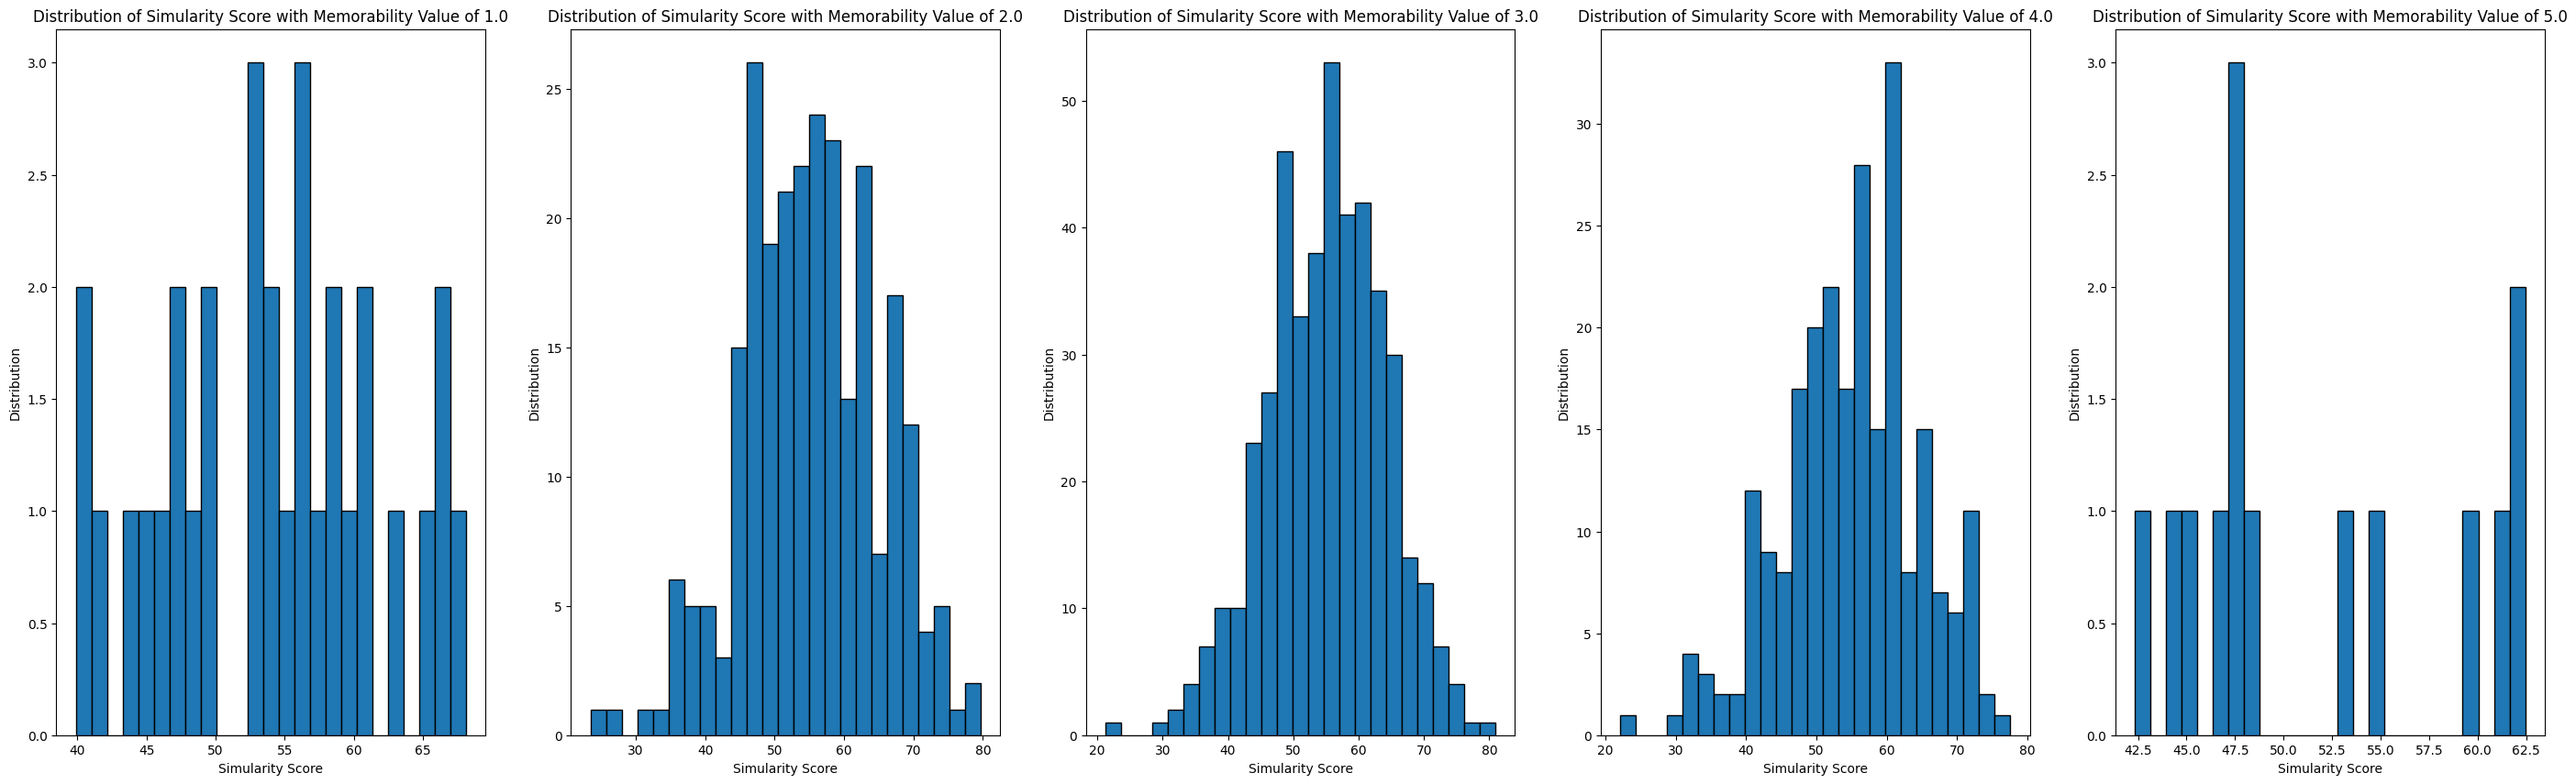

In [ ]:
from matplotlib import pyplot as plt

#Define subplot parameters
fig, axes = plt.subplots(nrows=1, ncols=len(memorability_vals), figsize=(35, 10))

for ax in axes:
  ax.set_xlabel("Similarity Score")
  ax.set_ylabel("Distribution")

#Generate a new subplot based on each memorability score
index = 0
for val in memorability_vals:
  df2 = images_1k_df_dropped_sorted.loc[images_1k_df_dropped_sorted["Memorable"] == val]
  treatment_vals = df2["Similarity Score"].tolist()
  axes[index].hist(treatment_vals, align='mid', edgecolor='black', bins = 25)
  axes[index].set_title(f"Distribution of Similarity Score with Memorability Value of {val}")
  index = index + 1


### Histogram of Distribution of Similarity Scores by Race

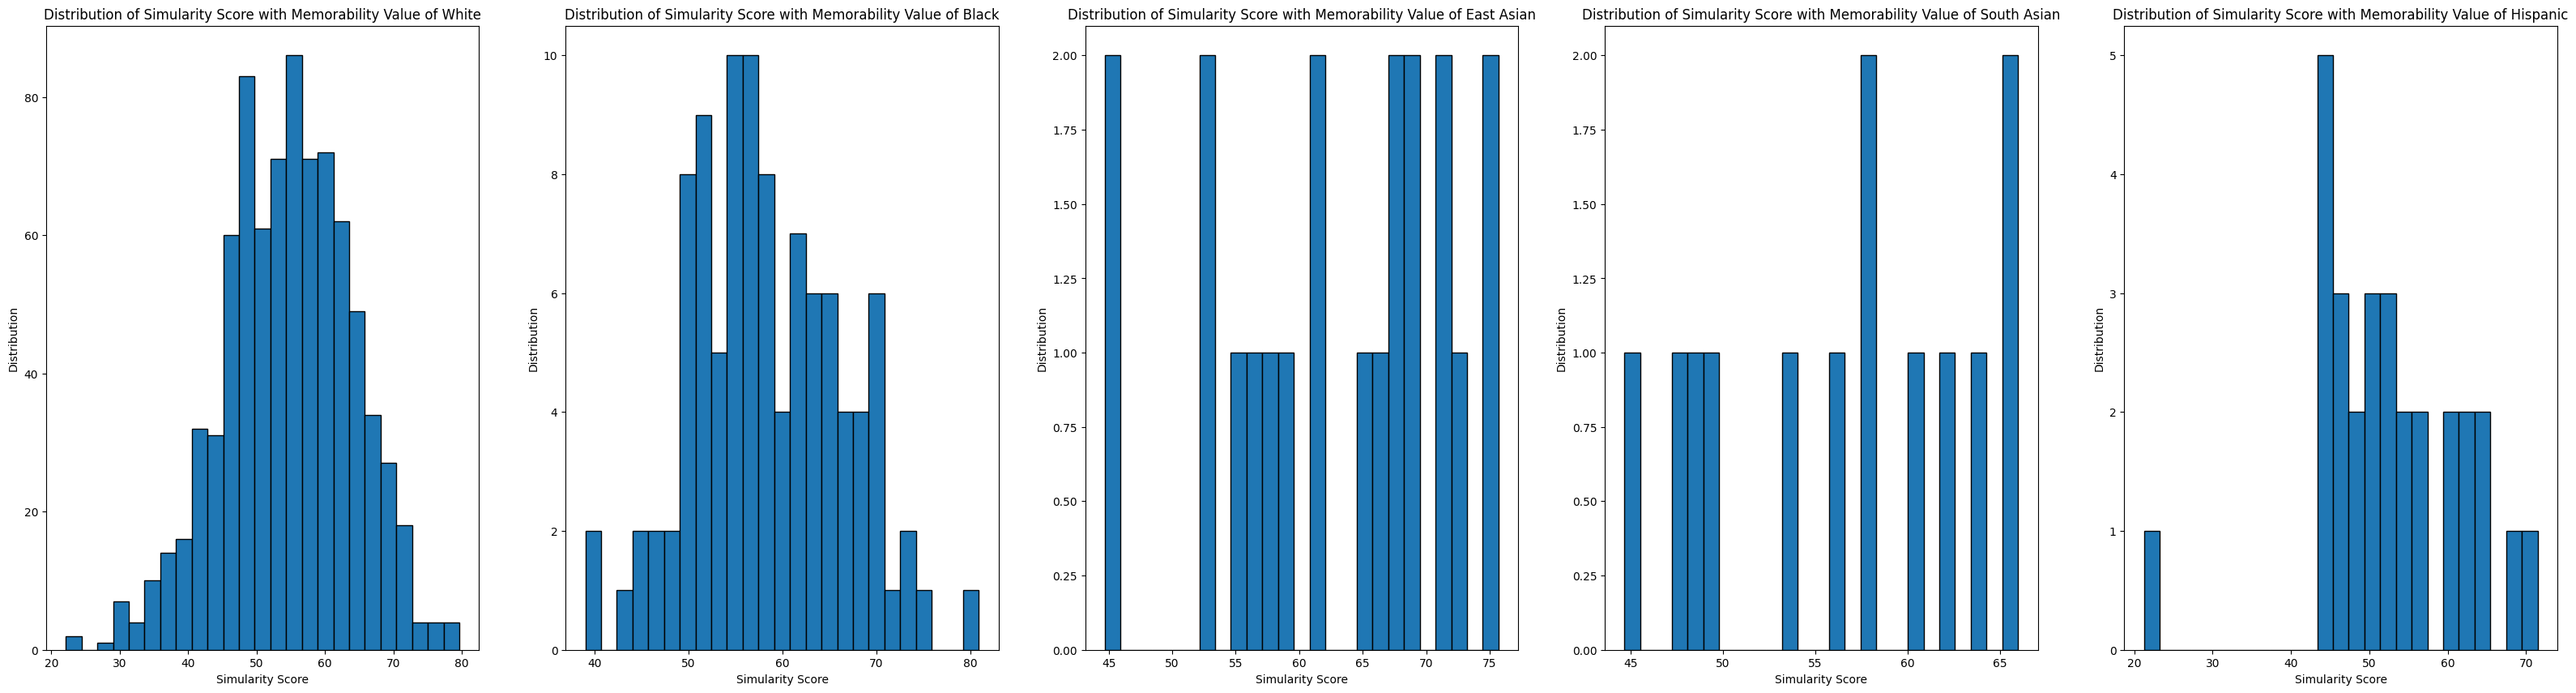

In [ ]:
race_dict = {1.0: "White", 2.0: "Black", 3.0: "East Asian", 4.0: "South Asian", 5.0: "Hispanic"}

#add row to original dataframe

fig, axes = plt.subplots(nrows=1, ncols=len(race_vals), figsize=(40, 10))

for ax in axes:
  ax.set_xlabel("Simularity Score")
  ax.set_ylabel("Distribution")

#Generate a new subplot based on each race identifier
index = 0
for val in race_vals:
  df2 = images_1k_df_dropped_sorted.loc[images_1k_df_dropped_sorted["Race"] == val]
  treatment_vals = df2["Simularity Score"].tolist()
  axes[index].hist(treatment_vals, align='mid', edgecolor='black', bins = 25)
  axes[index].set_title(f"Distribution of Simularity Score with Memorability Value of {race_dict[val]}")
  index = index + 1



## Pre-Data Analysis Setup

### Generating List of Similarity Scores for Each Memorability-Race Group

In [ ]:

memorability_vals_new = [2.0, 3.0, 4.0]

treatment_lis = [] #Create list to hold Simularity Scores for each memorability-race treatment pair
for val in memorability_vals_new: #Iterate through each value for memorability
  df2 = images_1k_df_dropped_sorted.loc[images_1k_df_dropped_sorted["Memorable"] == val] #Subset original dataframe
  for race in race_vals: #Iterate through each race classifer
    df3 = df2.loc[df2["Race"] == race] #Subset dataframe
    treatment_vals = df3["Simularity Score"].tolist() #Convert Simularity Score column into list
    treatment_lis.append(treatment_vals) #Add list of Simularity Scores into original list

treatment_lis

[[79.66,
  50.32,
  46.8,
  49.34,
  63.57,
  69.37,
  48.98,
  60.72,
  67.52,
  52.29,
  42.1,
  46.98,
  64.6,
  51.85,
  45.86,
  57.87,
  55.16,
  57.55,
  66.21,
  74.68,
  66.84,
  55.07,
  49.37,
  45.95,
  55.13,
  57.45,
  39.11,
  56.12,
  49.74,
  51.29,
  55.2,
  36.93,
  57.64,
  38.41,
  48.08,
  62.53,
  69.85,
  35.54,
  56.68,
  35.78,
  50.58,
  50.98,
  54.86,
  37.3,
  72.03,
  45.62,
  59.3,
  56.57,
  52.16,
  63.05,
  49.47,
  59.8,
  60.44,
  59.31,
  71.99,
  63.65,
  46.78,
  40.01,
  54.61,
  47.13,
  45.28,
  45.45,
  47.93,
  41.4,
  50.96,
  61.04,
  62.61,
  45.07,
  61.84,
  68.21,
  58.32,
  55.32,
  58.71,
  75.01,
  51.83,
  63.8,
  53.53,
  74.53,
  49.44,
  68.88,
  64.49,
  43.67,
  57.96,
  43.98,
  48.49,
  54.91,
  57.21,
  55.82,
  33.24,
  53.95,
  54.46,
  46.24,
  57.62,
  55.94,
  47.48,
  53.87,
  60.19,
  53.85,
  26.76,
  59.53,
  62.12,
  62.15,
  49.69,
  36.51,
  68.32,
  46.46,
  49.3,
  63.17,
  47.8,
  68.69,
  66.44,
  63.04,
  4

In [ ]:
#Only look at anova for statisitical difference in statistical scores across the 2.0, 3.0, and 4.0 memorability groups, as these groups contain data on every race

race_dict = {1.0: "W", 2.0: "B", 3.0: "EA", 4.0: "SA", 5.0: "H"} #Dictionary for race identifiers
df_treatments = pd.DataFrame(treatment_lis).T #Create dataframe based on our nested list of Simularity Scores

df_treatments.columns = [f"{int(memorability)}{race_dict[race]}" for memorability in memorability_vals_new for race in race_vals] #Create columns corresponding to each memorability-race treatment pair

df_treatments.columns



Index(['2W', '2B', '2EA', '2SA', '2H', '3W', '3B', '3EA', '3SA', '3H', '4W',
       '4B', '4EA', '4SA', '4H'],
      dtype='object')

### Preprocessing Data for ANOVA Analysis in R

In [ ]:
#Melt dataframe for ANOVA analysis

df_treatments_melt = pd.melt(df_treatments.reset_index(), id_vars=['index'], value_vars= df_treatments.columns.tolist())
df_treatments_melt.columns = ['index', 'treatment', 'value']



sum_sq     df         F    PR(>F)
C(treatment)   2830.633862   14.0  2.357115  0.003251
Residual      79516.027984  927.0       NaN       NaN

#### Converting dataframe into textfile

In [ ]:
with open('/content/drive/MyDrive/Data Ethics Final Project Drive/output.txt', 'w') as f:
    f.write(df_treatments_melt.to_string(index=False))